In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.6 MB/s eta 0:00:00


In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.7 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
MODEL_NAME = "klue/bert-base"
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# DATASET_URL = "https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv"
DATASET_NAME = "/content/drive/MyDrive/Colab Notebooks/data.csv"
# urllib.request.urlretrieve(DATASET_URL,
#                            filename = DATASET_NAME
#                            )


In [8]:
data = pd.read_csv(DATASET_NAME)
data.head()

,Title,Contents,"label(긍정1, 부정0)"
0,태권도 유단자들의 살인 발차기…23살 청년을 죽였다[그해 오늘],[이데일리 한광범 기자] 2020년 1월 1일 새벽 3시 무렵. 새해를 맞아 여자친...,0
1,"다신 보고 싶지 않은 ‘이 사진’…세상에서 가장 괴로운 뉴스 [지구, 뭐래?]",[헤럴드경제 = 김상수 기자]정말 춥다. 조금만 기억을 되돌려보자. 겨울이 맞나 싶...,0
2,"'돈 많은 줄 알았는데'…래퍼 도끼, 세금 체납에 건보료도 밀려",래퍼 도끼(33)가 최근 3억 원 가량의 세금을 체납한 것으로 알려진 가운데 건강보...,0
3,"""생명 위협 느껴"" 히잡 벗은 이란 女 체스 선수, 보복 무서워 간 곳은",히잡을 벗고 국제 대회에 참가해 세계적 관심을 받았던 이란의 여성 체스선수 사라 카...,0
4,나체로 창고에 가둬' 지적장애 동생 학대한 친누나 부부 체포,말을 듣지 않는다는 이유로 지적장애인인 동생을 집 창고에 가두고 학대한 혐의로 20...,0


In [9]:
X_data = data['Title']
y_data = data['label(긍정1, 부정0)']

In [10]:
TEST_SIZE = 0.3 # Train: Test = 7 : 3 분리
RANDOM_STATE = 77
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y_data)

In [11]:
print(f"훈련 입력 데이터 개수: {len(X_train)}")
print(f"테스트 입력 데이터 개수: {len(X_test)}")

훈련 입력 데이터 개수: 445
테스트 입력 데이터 개수: 192


In [12]:
# 입력 데이터(문장) 길이 제한
MAX_SEQ_LEN = 256

In [13]:
def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []

    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)

        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros

        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

In [14]:
def convert_data_x(X_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments = [], [], []

    for X in tqdm(X_data):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)

        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros

        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)

    return [tokens, masks, segments]

In [15]:
# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)
# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

445it [00:00, 2098.62it/s]
192it [00:00, 1524.36it/s]


In [16]:
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

In [17]:
bert_output = bert_outputs[0]

In [18]:
DROPOUT_RATE = 0.5
NUM_CLASS = 2
dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)
# binary-class classification 문제이므로 activation function은 sigmoid
sentiment_layer = tf.keras.layers.Dense(NUM_CLASS, activation='sigmoid', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_layer)

In [19]:
# 옵티마이저 Rectified Adam 하이퍼파리미터 조정
OPTIMIZER_NAME = 'RAdam'
LEARNING_RATE = 5e-5
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                          total_steps = TOTAL_STEPS,
                                          warmup_proportion = WARMUP_PROPORTION,
                                          min_lr = MIN_LR,
                                          epsilon = EPSILON,
                                          clipnorm = CLIPNORM)

In [20]:
# 감정분류 모델 컴파일
sentiment_model.compile(optimizer = optimizer,
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics = ['accuracy'])

In [21]:
MIN_DELTA = 1e-3
PATIENCE = 5

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    min_delta = MIN_DELTA,
    patience = PATIENCE)

In [22]:
# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = './model/best_model.h5'
model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)

In [23]:
callbacks = [early_stopping, model_checkpoint]

In [24]:
EPOCHS = 100
BATCH_SZIE = 16

sentiment_model.fit(train_x, train_y,
                    epochs = EPOCHS,
                    shuffle = True,
                    batch_size = BATCH_SZIE,
                    validation_data = (test_x, test_y),
                    callbacks = callbacks
                    )

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5303
Epoch 1: val_loss improved from inf to 0.69238, saving model to ./model/best_model.h5
28/28 [==============================] - 75s 1s/step - loss: 0.6931 - accuracy: 0.5303 - val_loss: 0.6924 - val_accuracy: 0.6302
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5124
Epoch 2: val_loss improved from 0.69238 to 0.69201, saving model to ./model/best_model.h5
28/28 [==============================] - 37s 1s/step - loss: 0.6928 - accuracy: 0.5124 - val_loss: 0.6920 - val_accuracy: 0.7240
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.6157
Epoch 3: val_loss improved from 0.69201 to 0.69110, saving model to ./model/best_model.h5
28/28 [==============================] - 37s 1s/step - loss: 0.6919 - accuracy: 0.6157 - val_loss: 0.6911 - val_accuracy: 0.8281
Epoch 4/100
28/28 [==============================] - ETA: 0s -

In [25]:
# 최고 성능의 모델 불러오기
sentiment_model_best = tf.keras.models.load_model(BEST_MODEL_NAME,
                                                  custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [26]:
predicted_value = sentiment_model_best.predict(test_x)
predicted_label = np.argmax(predicted_value, axis = 1)

6/6 [==============================] - 5s 448ms/step


In [27]:
predicted_label

array([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0])

In [29]:
x = convert_data_x("디지털 기술이 따뜻한 목적으로 사용되며 중증 장애인의 사회 참여를 돕고 고용 창출도 하는 모습이어서 반갑다.")

100%|██████████| 60/60 [00:00<00:00, 4092.47it/s]


In [30]:
pre = sentiment_model_best.predict(x)
label = np.argmax(pre, axis = 1)

2/2 [==============================] - 4s 493ms/step


In [31]:
pre

array([[0.5025827 , 0.49985877],
       [0.49985722, 0.5061724 ],
       [0.52206665, 0.4610684 ],
       [0.47655407, 0.5462702 ],
       [0.48562306, 0.5312613 ],
       [0.53149587, 0.4429594 ],
       [0.4998197 , 0.50155383],
       [0.47655407, 0.5462702 ],
       [0.49943286, 0.50646   ],
       [0.48576108, 0.5269866 ],
       [0.4759683 , 0.5479648 ],
       [0.47655407, 0.5462702 ],
       [0.5080383 , 0.48964718],
       [0.5212779 , 0.46313518],
       [0.5275089 , 0.45165226],
       [0.49827766, 0.50750285],
       [0.47655407, 0.5462702 ],
       [0.50195485, 0.5018834 ],
       [0.5020053 , 0.5025408 ],
       [0.5066394 , 0.49119255],
       [0.5019933 , 0.50097656],
       [0.47655407, 0.5462702 ],
       [0.5098829 , 0.48456746],
       [0.5101052 , 0.48751515],
       [0.47655407, 0.5462702 ],
       [0.50279766, 0.5005337 ],
       [0.5098583 , 0.48589945],
       [0.4927901 , 0.5187877 ],
       [0.48433855, 0.5314208 ],
       [0.47655407, 0.5462702 ],
       [0.

In [32]:
label

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1])

In [33]:
np.mean(label)

0.5333333333333333

In [34]:
cl_report = classification_report(test_y, predicted_label, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
print(cl_report_df)

              precision  recall  f1-score  support
0                 0.981   0.963     0.972  109.000
1                 0.953   0.976     0.964   83.000
accuracy          0.969   0.969     0.969    0.969
macro avg         0.967   0.970     0.968  192.000
weighted avg      0.969   0.969     0.969  192.000


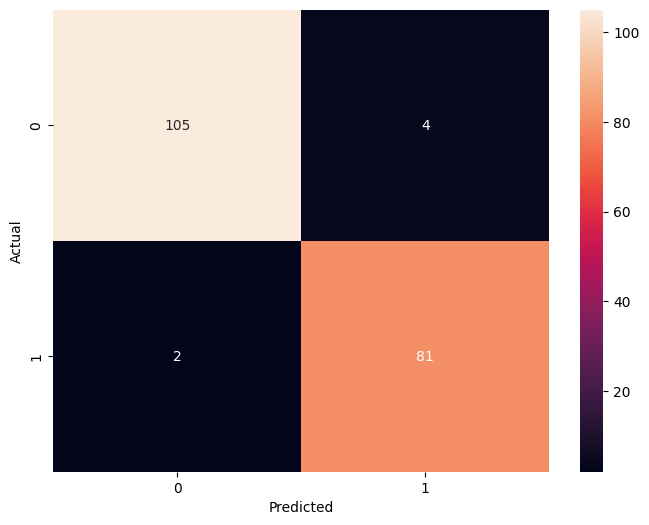

In [35]:
cf_matrix = confusion_matrix(test_y, predicted_label)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()